<a href="https://colab.research.google.com/github/dudeurv/SAM_MRI/blob/main/Basic_SAM_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) SAM (Segment Anything Model) Library

In [ ]:
# Install the SAM library from Facebook Research
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'

# Download the pre-trained SAM model path for later use
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done
--2023-11-22 22:31:54--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.59, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   241MB/s    in 13s     

2023-11-22 22:32:07 (183 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



# 2) Importing

In [ ]:
import sys
import PIL
import requests
import numpy as np
import matplotlib.pyplot as plt

# Append the parent directory ("..") to the system path to import modules from the parent directory
sys.path.append("..")

import torch

# Import specific functions and classes from the SAM library
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# 3) Setting up SAM

In [ ]:
# Check if a GPU is available for computation, else use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SAM model with the specified type and checkpoint, and move it to the selected device (GPU/CPU)
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)

# Initialize the automatic mask generator with the SAM model
mask_generator = SamAutomaticMaskGenerator(sam)

# 4) Understanding Model Layers

In [ ]:
# Access the image encoder component of the SAM model
sam.image_encoder

ImageEncoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-31): 32 x Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (lin1): Linear(in_features=1280, out_features=5120, bias=True)
        (lin2): Linear(in_features=5120, out_features=1280, bias=True)
        (act): GELU(approximate='none')
      )
    )
  )
  (neck): Sequential(
    (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): LayerNorm2d()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): LayerNorm2d()
  )
)

*From the code above we learn the following:*

**ImageEncoderViT:** This means the image encoder is a type of Vision Transformer (ViT).

**(proj):** The initial layer that processes the input image.
It uses a 2D convolution (Conv2d) to create embeddings from image patches.

**(blocks):** Describes a series of blocks in the model, each consisting of several layers.

**(neck):** This is a sequential layer comprising a series of convolutional and normalization layers.

# 5) Loading & Segmenting an Image

The **mask_generator** is an instance of the SamAutomaticMaskGenerator class from the SAM library.

**Function Call - generate(image):**
The generate function of the mask_generator object is called with the image as its argument.
The model then applies its trained neural network to the image.

**The masks List:**
The masks list contains multiple dictionaries, representing each segment.

The key 'segmentation' refers to a binary array where True values indicate pixels that are part of the segment, and False values represent pixels that are not.

In [ ]:
# Define the URL of the image to be segmented
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"

# Fetch the image from the URL and open it as a PIL Image object
img = PIL.Image.open(requests.get(image_url, stream=True).raw)

# Convert the PIL Image into a numpy array for processing
image = np.array(img)

# Generate segmentation masks for the image using the SAM model
masks = mask_generator.generate(image)

# Print the keys of the first mask dictionary to understand its structure
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


# 6) Plot the Results

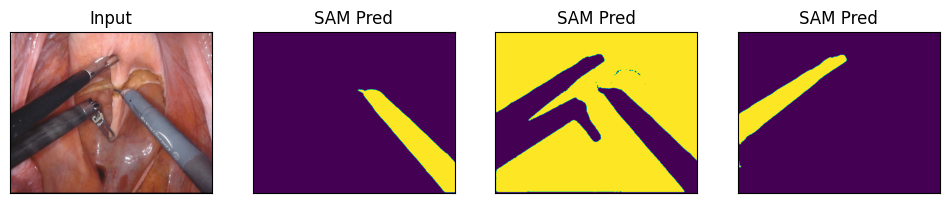

In [ ]:
# Define the number of images to display (original + 3 masks)
num_img = 4

# Create a figure with subplots for each image
fig, ax = plt.subplots(1, num_img, figsize=(3*num_img,7), subplot_kw=dict(xticks=[],yticks=[]))

# Display the original image in the first subplot
ax[0].imshow(image)
ax[0].set_title('Input')

# Display the first three segmentation masks in the next subplots
for i in range(1, num_img):
    ax[i].imshow(masks[i-1]['segmentation'])
    ax[i].set_title('SAM Pred')